In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def Generate_Data(num_samples: int, test_size=0.2):
    """
    Generates and splits data into training and testing sets.
    Normalization is no longer done here.
    """
    X_list = []
    y_list = []

    while len(X_list) < num_samples:
        multiplicand_val = np.random.randint(100, 1000)
        multiplier_val = np.random.randint(10, 100)

        multiplicand_str = str(multiplicand_val)
        multiplier_str = str(multiplier_val)

        # We can now include zeros to make the problem more realistic
        # if '0' in multiplicand_str or '0' in multiplier_str:
        #     continue

        product_val = multiplicand_val * multiplier_val
        
        input_digits = [int(d) for d in multiplicand_str] + [int(m) for m in multiplier_str]
        X_list.append(input_digits)

        product_str = str(product_val).zfill(5)
        output_digits = [int(p) for p in product_str]
        y_list.append(output_digits)

    # Convert to numpy arrays before splitting
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # The output 'y' still needs to be normalized for the loss function
    y_train_normalized = y_train / 9.0
    y_test_normalized = y_test / 9.0
    
    # Return raw X (preprocessing happens later) and normalized y
    return X_train, y_train_normalized, X_test, y_test_normalized

In [3]:
def transform_and_normalize_input(X):
    """
    Transforms input digits to their place values and normalizes them globally.
    
    Args:
        X (np.ndarray): Input data with raw digits, shape (num_samples, 5).
        
    Returns:
        np.ndarray: Processed data ready for the model, shape (num_samples, 5).
    """
    # Define the place value for each of the 5 input positions
    place_values = np.array([100, 10, 1, 10, 1])
    
    # Apply the transformation by multiplying each digit by its place value
    X_transformed = X * place_values
    
    # Normalize globally by the maximum possible value (9 * 100 = 900)
    # This scales all features to a [0, 1] range while preserving their
    # relative magnitudes.
    X_normalized = X_transformed / 900.0
    
    return X_normalized

In [4]:
def Activation_Function(x, name='relu', derivative=False):
    if name == 'relu':
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)
    
    elif name == 'leaky_relu':
        alpha = 0.01 # The 'leak' factor
        if derivative:
            return np.where(x > 0, 1, alpha)
        return np.maximum(alpha * x, x)
    
    elif name == 'sigmoid':
        s = 1 / (1 + np.exp(-x))
        if derivative:
            return s * (1 - s)
        return s
    
    return x # Default to linear activation

In [5]:
def Initialize_Network(layer_dims, layer_activations):
    """
    Initializes the network with specified dimensions and activation functions.
    
    Arguments:
    layer_dims -- list containing the size of each layer
    layer_activations -- list of strings specifying the activation for each layer (e.g., ['relu', 'relu', 'sigmoid'])
    
    Returns:
    parameters -- dictionary containing W, b, and activation for each layer
    """
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        # He Initialization for weights
        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        # Initialize biases to zero
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
        # Store the activation function for this layer
        parameters[f'activation{l}'] = layer_activations[l-1] # l-1 to match list index
        
    return parameters

In [6]:
def Forward_Propagation(X, parameters):
    cache = {}
    A = X.T
    L = len(parameters) // 3 # Now 3 items per layer: W, b, activation
    cache['A0'] = A

    for l in range(1, L + 1): # Loop through all layers
        A_prev = A
        W = parameters[f'W{l}']
        b = parameters[f'b{l}']
        activation = parameters[f'activation{l}']
        
        Z = np.dot(W, A_prev) + b
        A = Activation_Function(Z, name=activation)
        
        cache[f'A{l}'] = A
        cache[f'Z{l}'] = Z
        cache[f'activation{l}'] = activation # Store activation for backprop

    # The final activation AL is just A from the last loop iteration
    AL = A
    return AL, cache

In [7]:
def Compute_Loss(AL, Y):
    m = Y.shape[0]
    # Mean Squared Error Loss
    cost = np.mean((AL - Y.T)**2)
    cost = np.squeeze(cost)
    return cost

In [8]:
def Backward_Propagation(AL, Y, parameters, cache):
    grads = {}
    L = len(parameters) // 3
    m = Y.shape[0]
    Y = Y.T

    dAL = 2 * (AL - Y) / m
    
    # --- For the last layer (L) ---
    current_cache_Z = cache.get(f'Z{L}')
    current_cache_A_prev = cache.get(f'A{L-1}')
    activation = cache.get(f'activation{L}') # Get activation from cache
    
    dZ = dAL * Activation_Function(current_cache_Z, name=activation, derivative=True)
    
    grads[f'dW{L}'] = np.dot(dZ, current_cache_A_prev.T)
    grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(parameters[f'W{L}'].T, dZ)

    # --- For the remaining layers ---
    for l in reversed(range(1, L)):
        current_cache_Z = cache.get(f'Z{l}')
        current_cache_A_prev = cache.get(f'A{l-1}')
        activation = cache.get(f'activation{l}') # Get activation from cache
        
        dZ = dA_prev * Activation_Function(current_cache_Z, name=activation, derivative=True)
        
        grads[f'dW{l}'] = np.dot(dZ, current_cache_A_prev.T)
        grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(parameters[f'W{l}'].T, dZ)
        
    return grads

In [9]:
def Train(X, Y, parameters, epochs, learning_rate, batch_size=64, grad_clip_threshold=1.0):
    
    L = len(parameters) // 3 
    costs = []
    m = X.shape[0] # Number of training samples

    for i in range(epochs):
        epoch_cost = 0
        
        # --- Mini-Batch Logic ---
        # First, shuffle the data
        permutation = np.random.permutation(m)
        shuffled_X = X[permutation, :]
        shuffled_Y = Y[permutation, :]

        # Then, iterate over mini-batches
        for j in range(0, m, batch_size):
            # Get the current batch
            X_batch = shuffled_X[j:j + batch_size, :]
            Y_batch = shuffled_Y[j:j + batch_size, :]
            
            # --- The rest is your original training logic, but on the batch ---
            AL, cache = Forward_Propagation(X_batch, parameters)
            cost = Compute_Loss(AL, Y_batch)
            epoch_cost += cost
            
            grads = Backward_Propagation(AL, Y_batch, parameters, cache)

            # Gradient Clipping
            norm = 0
            for l in range(1, L + 1):
                norm += np.linalg.norm(grads[f'dW{l}'])**2
                norm += np.linalg.norm(grads[f'db{l}'])**2
            norm = np.sqrt(norm)
            
            if norm > grad_clip_threshold:
                for l in range(1, L + 1):
                    grads[f'dW{l}'] = (grads[f'dW{l}'] / norm) * grad_clip_threshold
                    grads[f'db{l}'] = (grads[f'db{l}'] / norm) * grad_clip_threshold

            # Update parameters
            for l in range(1, L + 1):
                parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
                parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']
        
        # --- End of Mini-Batch Loop ---
        
        avg_epoch_cost = epoch_cost / (m / batch_size)
        if i % 100 == 0 or i == epochs - 1:
            print(f"Cost after epoch {i}: {avg_epoch_cost}")
            costs.append(avg_epoch_cost)
            
    return parameters, costs

In [10]:
# New, smarter Predict function
def Predict(X_raw, parameters):
    """
    Takes raw digits, preprocesses them, and returns a prediction.
    """
    # First, process the raw input using our new function
    X_processed = transform_and_normalize_input(X_raw)
    
    # Then, perform forward propagation on the processed data
    AL, _ = Forward_Propagation(X_processed, parameters)
    
    # De-normalize the output to get the final digit predictions
    predictions = np.round(AL * 9.0)
    return predictions.T.astype(int)

In [11]:
def test_edge_cases(trained_parameters):
    """
    Tests the trained model on inputs containing zeros and negative numbers.
    The Predict() function now handles all necessary preprocessing.
    """
    print("\n--- Testing Edge Cases (Inputs the Model Has Not Been Trained On) ---")
    
    # Test case 1: Input with a zero
    test_zero_raw = np.array([[1, 2, 0, 3, 4]])
    prediction_zero = Predict(test_zero_raw, trained_parameters)
    print(f"Input with zero: {test_zero_raw[0]}")
    print(f"Model prediction: {prediction_zero[0]}")
    print("-" * 20)

    # Test case 2: Input with a negative number
    test_negative_raw = np.array([[-1, 5, 2, 8, 9]])
    prediction_negative = Predict(test_negative_raw, trained_parameters)
    print(f"Input with negative number: {test_negative_raw[0]}")
    print(f"Model prediction: {prediction_negative[0]}")
    print("-" * 20)

In [12]:
def Calculate_Metrics(predictions, y_true_normalized):
    """
    Calculates and prints the model's accuracy.
    """
    # Denormalize the true labels to compare with integer predictions
    y_true = np.round(y_true_normalized * 9.0).astype(int)

    # 1. Exact Match Accuracy: Percentage of samples where all 5 digits are correct
    exact_matches = np.all(predictions == y_true, axis=1).sum()
    total_samples = y_true.shape[0]
    exact_match_accuracy = (exact_matches / total_samples) * 100

    # 2. Digit-wise Accuracy: Percentage of all individual digits that are correct
    correct_digits = (predictions == y_true).sum()
    total_digits = y_true.size
    digit_wise_accuracy = (correct_digits / total_digits) * 100

    print("\n--- Model Performance Metrics ---")
    print(f"Exact Match Accuracy: {exact_match_accuracy:.2f}%")
    print(f"Digit-wise Accuracy: {digit_wise_accuracy:.2f}%")
    print("-" * 33)

In [13]:
def Plot_Cost(costs, learning_rate):
    """
    Plots the cost over epochs to visualize training progress.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(costs)
    plt.ylabel('Cost (MSE)')
    plt.xlabel('Epochs')
    plt.title(f'Cost Reduction Over Epochs (LR = {learning_rate})')
    plt.grid(True)
    plt.show()

Generating and splitting data...
Data generation complete.

Starting model training...
Cost after epoch 0: 0.21033807032774926
Cost after epoch 100: 0.08306787743707711
Cost after epoch 200: 0.08281066480051436
Cost after epoch 300: 0.08256828114066178
Cost after epoch 400: 0.08227824016293125
Cost after epoch 500: 0.08186057243375783
Cost after epoch 600: 0.08147555362809433
Cost after epoch 700: 0.08115917989768119
Cost after epoch 800: 0.08086011949248244
Cost after epoch 900: 0.08068730981220404
Cost after epoch 1000: 0.08056067890042488
Cost after epoch 1100: 0.08046176235683178
Cost after epoch 1200: 0.08031933920510226
Cost after epoch 1300: 0.08027381829243418
Cost after epoch 1400: 0.08018213383638599
Cost after epoch 1500: 0.08009232262729866
Cost after epoch 1600: 0.0800265201231319
Cost after epoch 1700: 0.07993036730222727
Cost after epoch 1800: 0.07984736696501445
Cost after epoch 1900: 0.0797673251803375
Cost after epoch 1999: 0.07969405848167792
Training complete.

--- 

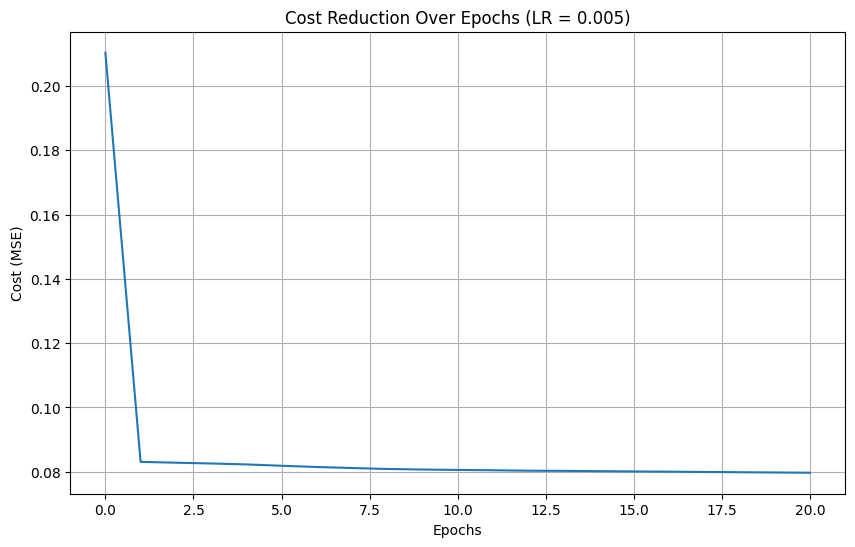

In [14]:
if __name__ == "__main__":
    # 1. Define Hyperparameters
    NUM_SAMPLES = 20000
    LAYER_DIMS = [5, 64, 32, 5] 
    ACTIVATIONS = ['leaky_relu', 'leaky_relu', 'leaky_relu', 'sigmoid']
    EPOCHS = 2000
    LEARNING_RATE = 0.005
    BATCH_SIZE = 64

    # 2. Generate and split training and testing data
    print("Generating and splitting data...")
    # The function now returns four items
    X_train_raw, y_train_norm, X_test_raw, y_test_norm = Generate_Data(NUM_SAMPLES)
    print("Data generation complete.")

    # 3. Preprocess the input data
    X_train_processed = transform_and_normalize_input(X_train_raw)

    # 4. Train the model ONLY on the training data
    print("\nStarting model training...")
    parameters = Initialize_Network(LAYER_DIMS, ACTIVATIONS)
    trained_parameters, costs = Train(X_train_processed, y_train_norm, parameters, EPOCHS, LEARNING_RATE, batch_size=BATCH_SIZE)
    print("Training complete.")
    
    # 5. Evaluate on the Training Set (to check for overfitting)
    print("\n--- Evaluating on Training Set ---")
    train_predictions = Predict(X_train_raw, trained_parameters)
    Calculate_Metrics(train_predictions, y_train_norm)

    # 6. Evaluate on the Test Set (the true measure of performance)
    print("\n--- Evaluating on Test Set ---")
    test_predictions = Predict(X_test_raw, trained_parameters)
    Calculate_Metrics(test_predictions, y_test_norm)

    # 7. Test on a valid, unseen example
    print("\n--- Testing on a valid, unseen example ---")
    test_input_raw = np.array([[1, 2, 3, 4, 5]]) 
    prediction = Predict(test_input_raw, trained_parameters)
    print(f"Input: {test_input_raw[0]}")
    print(f"Expected Output (123 * 45): [0 5 5 3 5]")
    print(f"Model Prediction: {prediction[0]}")

    # 8. Run the standalone test for edge cases
    test_edge_cases(trained_parameters)
    
    # 9. Plot the training cost graph
    Plot_Cost(costs, LEARNING_RATE)